# NODE

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np


# Load cleaned dataset
df_clean = pd.read_csv("./data/pred_maintenance_cleaned.csv")

# Feature/target split
X = df_clean.drop(columns=['Machine failure'])
y = df_clean['Machine failure']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to float32 for torch
X_train_np = X_train.values.astype("float32")
X_test_np = X_test.values.astype("float32")
y_train_np = y_train.values.astype("int64")
y_test_np = y_test.values.astype("int64")

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


## Model training

In [12]:
from torch import nn
from skorch import NeuralNetClassifier

# Redefine network (if needed)
class NodeLikeNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# Define custom loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Initialize NODE model
node_model = NeuralNetClassifier(
    NodeLikeNet,
    module__input_dim=X_train_np.shape[1],
    max_epochs=40,               # increased epochs
    lr=1e-4,                     # lower learning rate
    criterion=loss_fn,           # use weighted loss
    batch_size=128,
    iterator_train__shuffle=True,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


# Train with timing
start_time = time.time()
node_model.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

print(f"Training time: {training_time:.4f} seconds")


Training time: 1.5437 seconds


Predict and evaluate

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.85      1932
           1       0.12      0.96      0.21        68

    accuracy                           0.75      2000
   macro avg       0.56      0.85      0.53      2000
weighted avg       0.97      0.75      0.83      2000



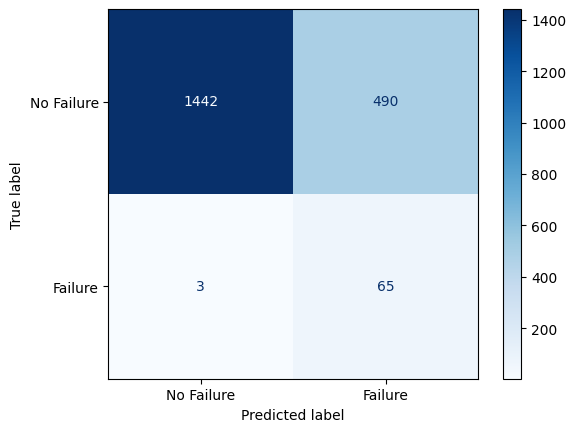

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = node_model.predict(X_test_np)

# Evaluation report
report = classification_report(y_test_np, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test_np, y_pred)

# Print report
print("Classification Report:")
print(classification_report(y_test_np, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Failure", "Failure"])
disp.plot(cmap="Blues")


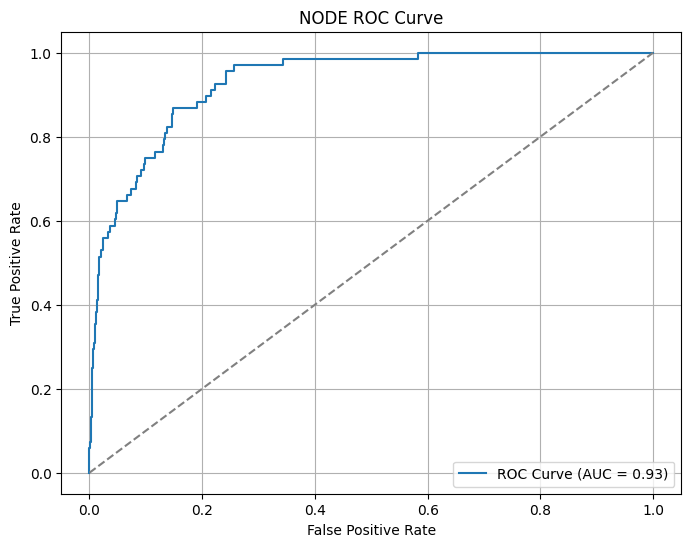

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict class probabilities
y_proba = node_model.predict_proba(X_test_np)[:, 1]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_np, y_proba)
roc_auc = roc_auc_score(y_test_np, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("NODE ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [15]:
import csv

# Select key metrics from the report
metrics = {
    "Model": "NODE",
    "Accuracy": report["accuracy"],
    "Precision": report["1"]["precision"],
    "Recall": report["1"]["recall"],
    "F1-score": report["1"]["f1-score"],
    "Training Time (s)": training_time
}

# Output path
output_path = "./data/node_metrics.csv"

# Save to CSV
with open(output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics saved to {output_path}")


Metrics saved to ./data/node_metrics.csv
